In [1]:
import pandas as pd
import numpy as np

import json
import pickle
import itertools
#from flask import *

from geopy.distance import distance, geodesic
import time
import matplotlib.pyplot as plt
from overpy.exception import OverpassTooManyRequests, OverpassGatewayTimeout
import importlib
import geo_utils as geou
import warnings
#import geo_consts as gc

In [2]:
geou = importlib.reload(geou)
geouconn = geou.OverPassConnector()

warnings.filterwarnings('ignore')

In [3]:
test_lat = 55.736250
test_lon = 37.594180

# Тестовый набор банкоматов

In [4]:
#geo_dict = {'Банкомат': ['amenity=atm', 10000]}
atm_desc = [['amenity=atm'], 20000]

In [9]:
%%time
for i in range(10):
    try:
        osm_nodes = geouconn.count_infrastructure_around_point((test_lat, test_lon), radius=atm_desc[1], tags=atm_desc[0])
        break
    except OverpassTooManyRequests:
        time.sleep(2)
    except OverpassGatewayTimeout:
        time.sleep(10)
    except:
        time.sleep(2)

Wall time: 1.61 s


In [10]:
test_long_lst = list(map(lambda x: [float(x.lat), float(x.lon)], osm_nodes))

In [11]:
len(test_long_lst)

2319

In [12]:
import random

In [13]:
random.seed(42)
test_short_lst = random.choices(test_long_lst, k=50)

In [14]:
dict_atm={}
for i,coord in zip(range(len(test_short_lst)), test_short_lst):
    dict_atm[i] = coord 

In [15]:
test_short_lst_pairs = list(itertools.combinations(dict_atm.keys(), 2))

In [16]:
test_short_lst_pairs_double = test_short_lst_pairs + [(x[1], x[0]) for x in test_short_lst_pairs]

In [17]:
len(test_short_lst_pairs_double)

2450

In [24]:
test_short_lst_pairs_double_coord = list(map(lambda x: (dict_atm[x[0]], dict_atm[x[1]]), test_short_lst_pairs_double))

# Расстояние между точками

In [5]:
osrmuconn = geou.OSRMConnector()

In [ ]:
dist_straight_m = list(map(lambda x: np.round(geou.geodistanse(x[0][0], x[0][1], x[1][0], x[1][1])*1000,2), test_short_lst_pairs_double_coord))

In [28]:
%%time
bycar_dist_center = map(lambda x: osrmuconn.get_route_car((x[0][0], x[0][1]), (x[1][0], x[1][1])), test_short_lst_pairs_double_coord)

Wall time: 0 ns


In [32]:
# 1 кейс - 0.5 сек.

In [33]:
car_distance_m = list(map(lambda x: x['distance'], bycar_dist_center))
car_distance_min = list(map(lambda x: np.round(x['duration'] / 60, 2), bycar_dist_center))

In [34]:
#тест

In [35]:
test_short_lst_pairs_double_coord[0]

([55.8084292, 37.5292915], [55.8114155, 37.3864134])

In [36]:
test_short_lst_pairs_double_coord[1225]

([55.8114155, 37.3864134], [55.8084292, 37.5292915])

In [37]:
#время без учета пробок -1-2 мин совпадает с яндексом.
#нужно учитывать пробки - увеличивать время
#учитывать время обслуживания

In [ ]:
car_distance_min[1225]

In [213]:
res_df = pd.DataFrame(test_short_lst_pairs_double, columns=['start_point_id', 'end_point_id'])
res_df['start_point'] = [x[0] for x in test_short_lst_pairs_double_coord]
res_df['end_point'] = [x[1] for x in test_short_lst_pairs_double_coord]
res_df['car_distance_min'] = car_distance_min
res_df['car_distance_m'] = car_distance_m

In [214]:
#res_df.to_csv('test_base_coordinates.csv', index=False)

In [7]:
res_df = pd.read_csv('test_base_coordinates.csv')

In [8]:
res_df

,start_point_id,end_point_id,start_point,end_point,car_distance_min,car_distance_m
0,0,1,"[55.762316, 37.5854656]","[55.8114155, 37.3864134]",21.61,18241.1
1,0,2,"[55.762316, 37.5854656]","[55.774565, 37.5874377]",3.93,2535.0
2,0,3,"[55.762316, 37.5854656]","[55.807749, 37.570132]",12.61,7920.1
3,0,4,"[55.762316, 37.5854656]","[55.6385471, 37.3580205]",30.71,24676.5
4,0,5,"[55.762316, 37.5854656]","[55.8184048, 37.6152322]",14.24,9637.1
...,...,...,...,...,...,...
2445,48,46,"[55.87561, 37.6654784]","[55.7684031, 37.6246871]",18.70,14114.2
2446,49,46,"[55.8941329, 37.4497595]","[55.7684031, 37.6246871]",27.17,22280.2
2447,48,47,"[55.87561, 37.6654784]","[55.6303056, 37.6242314]",40.19,30255.2
2448,49,47,"[55.8941329, 37.4497595]","[55.6303056, 37.6242314]",43.07,38802.9


In [9]:
points_coordinate = np.array(test_short_lst)
num_points = len(points_coordinate)

NameError: name 'test_short_lst' is not defined

In [10]:
distance_matrix_df = pd.pivot_table(res_df, values='car_distance_min', index=['start_point_id'],
                       columns=['end_point_id'], aggfunc=np.sum).fillna(0)

In [11]:
distance_matrix = np.array(distance_matrix_df)
distance_matrix.shape

(50, 50)

In [24]:
with open('distance_matrix.txt','wb') as f:
    for line in distance_matrix:
        np.savetxt(f, line, fmt='%.2f')

In [26]:
d = pd.DataFrame(data=distance_matrix.astype(float))
d.to_csv('distance_matrix.csv', sep=' ', header=False, float_format='%.2f', index=False)

In [12]:
imput_matrix = [list(map(lambda x: int(np.ceil(x)), row)) for row in distance_matrix]

# Муравьиная колония

In [157]:
class ACO_TSP:  # класс алгоритма муравьиной колонии для решения задачи коммивояжёра
    def __init__(self, func, n_dim, size_pop=10, max_iter=20, distance_matrix=None, alpha=1, beta=2, rho=0.1):
        self.func = func
        self.n_dim = n_dim  # количество точек
        self.size_pop = size_pop  # количество муравьёв
        self.max_iter = max_iter  # количество итераций
        self.alpha = alpha  # коэффициент важности феромонов в выборе пути
        self.beta = beta  # коэффициент значимости расстояния
        self.rho = rho  # скорость испарения феромонов

        self.prob_matrix_distance = 1 / (distance_matrix + 1e-10 * np.eye(n_dim, n_dim))

        # Матрица феромонов, обновляющаяся каждую итерацию
        self.Tau = np.ones((n_dim, n_dim))
        # Путь каждого муравья в определённом поколении
        self.Table = np.zeros((size_pop, n_dim)).astype(int)
        self.y = None  # Общее расстояние пути муравья в определённом поколении
        self.generation_best_X, self.generation_best_Y = [], [] # фиксирование лучших поколений
        self.x_best_history, self.y_best_history = self.generation_best_X, self.generation_best_Y
        self.best_x, self.best_y = None, None

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            # вероятность перехода без нормализации
            prob_matrix = (self.Tau ** self.alpha) * (self.prob_matrix_distance) ** self.beta
            for j in range(self.size_pop):  # для каждого муравья
                # точка начала пути (она может быть случайной, это не имеет значения)
                self.Table[j, 0] = 0
                for k in range(self.n_dim - 1):  # каждая вершина, которую проходят муравьи
                    # точка, которая была пройдена и не может быть пройдена повторно
                    taboo_set = set(self.Table[j, :k + 1])
                    # список разрешённых вершин, из которых будет происходить выбор
                    allow_list = list(set(range(self.n_dim)) - taboo_set)
                    prob = prob_matrix[self.Table[j, k], allow_list]
                    prob = prob / prob.sum() # нормализация вероятности
                    next_point = np.random.choice(allow_list, size=1, p=prob)[0]
                    self.Table[j, k + 1] = next_point

            # рассчёт расстояния
            y = np.array([self.func(i) for i in self.Table])

            # фиксация лучшего решения
            index_best = y.argmin()
            x_best, y_best = self.Table[index_best, :].copy(), y[index_best].copy()
            self.generation_best_X.append(x_best)
            self.generation_best_Y.append(y_best)

            # подсчёт феромона, который будет добавлен к ребру
            delta_tau = np.zeros((self.n_dim, self.n_dim))
            for j in range(self.size_pop):  # для каждого муравья
                for k in range(self.n_dim - 1):  # для каждой вершины
                    # муравьи перебираются из вершины n1 в вершину n2
                    n1, n2 = self.Table[j, k], self.Table[j, k + 1]
                    delta_tau[n1, n2] += 1 / y[j]  # нанесение феромона
                # муравьи ползут от последней вершины обратно к первой
                n1, n2 = self.Table[j, self.n_dim - 1], self.Table[j, 0]
                delta_tau[n1, n2] += 1 / y[j]  # нанесение феромона

            self.Tau = (1 - self.rho) * self.Tau + delta_tau

        best_generation = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[best_generation]
        self.best_y = self.generation_best_Y[best_generation]
        return self.best_x, self.best_y

    fit = run

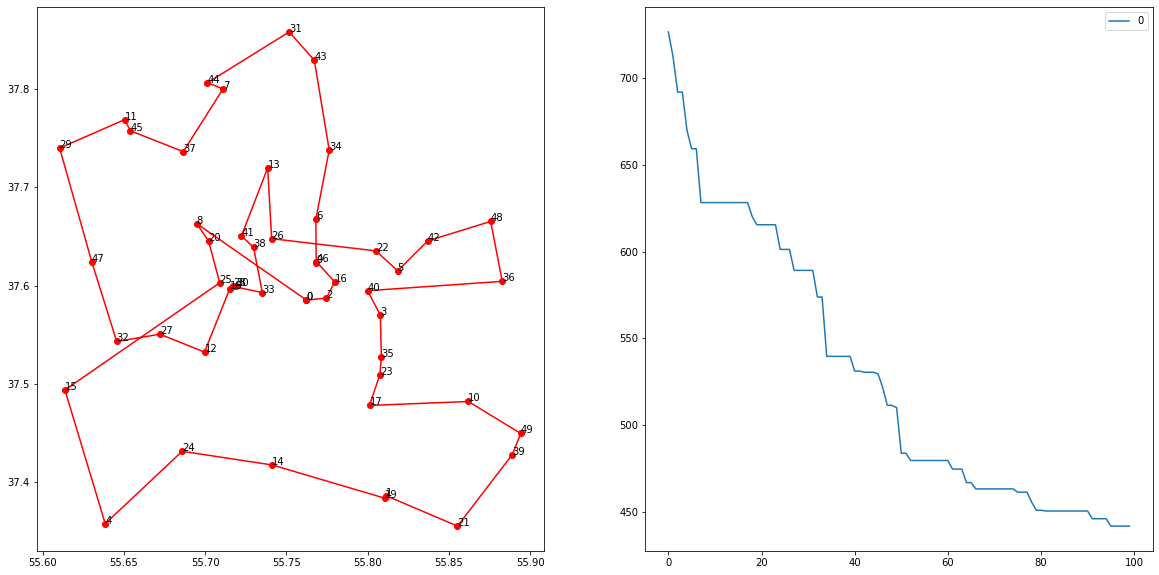

time of execution: 13.617581129074097 seconds


In [183]:
# вычисление длины пути
def cal_total_distance(routine):
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

def main():
    # создание объекта алгоритма муравьиной колонии
    aca = ACO_TSP(func=cal_total_distance, n_dim=num_points,
                  size_pop=50,  # количество муравьёв
                  max_iter=100, distance_matrix=distance_matrix)
    best_x, best_y = aca.run()

    # Вывод результатов на экран
    fig, ax = plt.subplots(1, 2)
    best_points_ = np.concatenate([best_x, [best_x[0]]])
    best_points_coordinate = points_coordinate[best_points_, :]
    for index in range(0, len(best_points_)):
        ax[0].annotate(best_points_[index], (best_points_coordinate[index, 0], best_points_coordinate[index, 1]))
    ax[0].plot(best_points_coordinate[:, 0],
               best_points_coordinate[:, 1], 'o-r')
    pd.DataFrame(aca.y_best_history).cummin().plot(ax=ax[1])
    # изменение размера графиков
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.show()
    return best_x, best_y

if __name__ == "__main__":
    start_time = time.time() # сохранение времени начала выполнения
    best_x, best_y = main() # выполнение кода
    print("time of execution: %s seconds" %abs (time.time() - start_time)) # вычисление времени выполнения

In [184]:
best_x

array([ 0,  2, 16, 46,  9,  6, 34, 43, 31, 44,  7, 37, 45, 11, 29, 47, 32,
       27, 12, 18, 30, 28, 33, 38, 41, 13, 26, 22,  5, 42, 48, 36, 40,  3,
       35, 23, 17, 10, 49, 39, 21,  1, 19, 14, 24,  4, 15, 25, 20,  8])

In [236]:
best_y

441.84

In [187]:
best_y/60 # часов

7.364

# Алгоритм Дейстры

In [ ]:
nodes = ('A', 'B', 'C', 'D', 'E', 'F', 'G')
distances = {
    'B': {'A': 5, 'D': 1, 'G': 2},
    'A': {'B': 5, 'D': 3, 'E': 12, 'F' :5},
    'D': {'B': 1, 'G': 1, 'E': 1, 'A': 3},
    'G': {'B': 2, 'D': 1, 'C': 2},
    'C': {'G': 2, 'E': 1, 'F': 16},
    'E': {'A': 12, 'D': 1, 'C': 1, 'F': 2},
    'F': {'A': 5, 'E': 2, 'C': 16}}
unvisited = {node: None for node in nodes} #using None as +inf
visited = {}
current = 'B'
currentDistance = 0
unvisited[current] = currentDistance
while True:
    for neighbour, distance in distances[current].items():
        if neighbour not in unvisited: continue
        newDistance = currentDistance + distance
        if unvisited[neighbour] is None or unvisited[neighbour] > newDistance:
            unvisited[neighbour] = newDistance
    visited[current] = currentDistance
    del unvisited[current]
    if not unvisited: break
    candidates = [node for node in unvisited.items() if node[1]]
    current, currentDistance = sorted(candidates, key = lambda x: x[1])[0]
print(visited)

# Задача коммивояжера на Python методом ветвей и границ(алгоритм Литтла)

In [512]:
def Min(lst,myindex):
    return min(x for idx, x in enumerate(lst) if idx != myindex)

#функция удаления нужной строки и столбцах
def Delete(matrix,index1,index2):
    del matrix[index1]
    for i in matrix:
        del i[index2]
    return matrix

#Функция вывода матрицы
def PrintMatrix(matrix):
    print("---------------")
    for i in range(len(matrix)):
        print(matrix[i])
    print("---------------")

In [586]:
imput_matrix = [list(map(lambda x: int(np.ceil(x)), row)) for row in distance_matrix]

In [514]:
%%time
#n=int(input())
n=50
matrix=[]
H=0
PathLenght=0
Str=[]
Stb=[]
res=[]
result=[]
StartMatrix=[]

#Инициализируем массивы для сохранения индексов
for i in range(n):
    Str.append(i)
    Stb.append(i)

#Вводим матрицу
#for i in range(n): matrix.append(list(map(int, input().split())))
matrix = imput_matrix

Wall time: 0 ns


In [515]:
	
#Сохраняем изначальную матрицу
for i in range(n):StartMatrix.append(matrix[i].copy())

In [516]:
for i in range(n): matrix[i][i]=float('inf')

In [517]:
while True:
    #Редуцируем
    #--------------------------------------
    #Вычитаем минимальный элемент в строках
    for i in range(len(matrix)):
        temp=min(matrix[i])
        H+=temp
        for j in range(len(matrix)):
            matrix[i][j]-=temp

    #Вычитаем минимальный элемент в столбцах    
    for i in range(len(matrix)):
        temp = min(row[i] for row in matrix)
        H+=temp
        for j in range(len(matrix)):
            matrix[j][i]-=temp
    #--------------------------------------
	
    #Оцениваем нулевые клетки и ищем нулевую клетку с максимальной оценкой
    #--------------------------------------
    NullMax=0
    index1=0
    index2=0
    tmp=0
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j]==0:
                tmp=Min(matrix[i],j)+Min((row[j] for row in matrix),i)
                if tmp>=NullMax:
                    NullMax=tmp
                    index1=i
                    index2=j
    #--------------------------------------

	#Находим нужный нам путь, записываем его в res и удаляем все ненужное
    res.append(Str[index1]+1)
    res.append(Stb[index2]+1)
	
    oldIndex1=Str[index1]
    oldIndex2=Stb[index2]
    if oldIndex2 in Str and oldIndex1 in Stb:
        NewIndex1=Str.index(oldIndex2)
        NewIndex2=Stb.index(oldIndex1)
        matrix[NewIndex1][NewIndex2]=float('inf')
    del Str[index1]
    del Stb[index2]
    matrix=Delete(matrix,index1,index2)
    if len(matrix)==1:break

In [518]:
res

[44,
 32,
 20,
 2,
 9,
 21,
 36,
 24,
 22,
 20,
 49,
 37,
 43,
 49,
 37,
 43,
 41,
 4,
 5,
 25,
 16,
 5,
 2,
 22,
 50,
 40,
 40,
 11,
 11,
 50,
 48,
 33,
 24,
 18,
 23,
 6,
 6,
 41,
 47,
 10,
 10,
 17,
 3,
 1,
 1,
 34,
 15,
 13,
 25,
 15,
 46,
 12,
 45,
 8,
 32,
 45,
 33,
 16,
 13,
 28,
 28,
 48,
 8,
 38,
 12,
 30,
 38,
 46,
 30,
 9,
 42,
 27,
 39,
 42,
 21,
 26,
 19,
 31,
 29,
 19,
 31,
 29,
 26,
 39,
 4,
 23,
 18,
 36,
 34,
 3,
 17,
 47,
 27,
 7,
 14,
 44,
 35,
 14]

In [425]:
#Формируем порядок пути
for i in range(0,len(res)-1,2):
	if res.count(res[i])<2:
		result.append(res[i])
		result.append(res[i+1])
for i in range(0,len(res)-1,2):
	for j in range(0,len(res)-1,2):
		if result[len(result)-1]==res[j]:
			result.append(res[j])
			result.append(res[j+1])
print("----------------------------------")
print(result)

In [519]:
#Считаем длину пути
for i in range(0,len(res)-1,2):
    if i==len(res)-2:
        PathLenght+=StartMatrix[res[i]-1][res[i+1]-1]
        PathLenght+=StartMatrix[res[i+1]-1][res[0]-1]
    else: PathLenght+=StartMatrix[res[i]-1][res[i+1]-1]
print(PathLenght)
print("----------------------------------")

430
----------------------------------


# Алгоритм Литтла 2 версия

In [189]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#------------------------------------------------------------------------------------
def distance(x1, y1, x2, y2):
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
#------------------------------------------------------------------------------------
def in_deep_matrix(p, y, x):
    # Возвращает новую матрицу меньшего размера, за вычитом строки и столбца
    return p.drop([y], axis = 0).drop([x], axis = 1)
#------------------------------------------------------------------------------------
def reduction_matrix(p):
    # Производим редуцирование матрицы, возвращаем нижнюю границу
    bottom_line = 0
    
    # Находим минимум по каждой строке и вычитаем его
    for index, row in p.iterrows():
        min = row.min()      
        if np.isinf(min):
            return np.inf        
        bottom_line += min
        for key, value in row.iteritems():
             p[key][index] -= min

    # Находим минимум по каждому столбцу и вычитаем его
    for key, value in p.iteritems(): 
        min = value.min()
        if np.isinf(min):
            return np.inf     
        bottom_line += min
        for index, row in value.iteritems():
            p[key][index] -= min

    return bottom_line
#------------------------------------------------------------------------------------
def partition_matrix(p):
    # Ищем элемент для разбиения матрицы на m1 и m2
    # Для этого производим оценку нулевых элементов матрицы
    max_sum = 0
    index_i = None
    index_j = None
    for index, row in p.iterrows():
        for key, value in p.iteritems():
            if p[key][index] == 0:
                min_i = np.inf
                min_j = np.inf

                for k, v in p[key].items():  # по столбецу
                    if k != index and v < min_i:
                        min_i = v

                for k, v in p.loc[index].items():
                    if k != key and v < min_j:
                        min_j = v
                        
                l = min_i + min_j
                if l > max_sum:
                    max_sum = l
                    index_i = index
                    index_j = key
                
    return [index_i, index_j, max_sum]
#------------------------------------------------------------------------------------
def reverse_index(l, i, j):
    # Находим обрытный индекс для матрицы    
    def in_dict(d, v):
        while v in d:
            v = d[v]
        return v
    
    ln = len(l)
    d1 = {l[k][0]: l[k][1] for k in range(0, ln, 1)}
    d2 = {l[k][1]: l[k][0] for k in range(0, ln, 1)}
    return [in_dict(d1, i), in_dict(d2, j)]

#------------------------------------------------------------------------------------
def evaluation_matrix(p, res, bottom_line):
    # Оценка матрицы, поиск решения
    if len(p) == 1:      
        res['steps'] += 1
        bottom_line += p.iat[0, 0] 

        # Если текущее решение лучше, запоминаем его
        if bottom_line < res['global_min']:
            res['global_min'] = bottom_line
            res['local_result'].append([p.index[0], p.columns[0]])       
            res['best_result'] = res['local_result'].copy()
            print('Решение лучше:', bottom_line, res['best_result'], 'шаг: ', res['steps'])         
        return
    
    # Производим редуцирование матрицы, возвращаем минимальную нижнюю границу
    bottom_line += reduction_matrix(p)
    if np.isinf(bottom_line):
        return
    
    max_sum = 0
    while True:
        res['steps'] += 1
        # Находим элемент для разбиения на подмножества m1 и m2
        i, j, max_sum = partition_matrix(p) 
        # Больше нет элементов для разбиения
        if i is None:
            return

        v_len = len(res['local_result'])
        # Рассматриваем m1 (соглашаемся на разбиение по элементу)
        if bottom_line < res['global_min']:
            res['local_result'].append([i, j])
            p1 = in_deep_matrix(p, i, j)
            # Вычёркиваем обратный элемент только для матрицы большей чем 2х2, чтоб не получить inf
            if len(p1) > 2: 
                i_reverse, j_reverse = reverse_index(res['local_result'], i, j)         
                p1[j_reverse][i_reverse] = np.inf
            evaluation_matrix(p1, res, bottom_line)

        # Рассматриваем m2 
        if res['global_min'] < bottom_line + max_sum:
            return
        p[j][i] = np.inf  # Исключаем не выбранный элемент
        res['local_result'] = res['local_result'][:v_len]  # Обрезаем список пути
        
#------------------------------------------------------------------------------------      
def return_res(res):
    l = res['best_result']
    if l:
        d = {l[k][0]: l[k][1] for k in range(len(l))}
        li =[]
        a = l[0][0]
        for v in range(len(l)):
            li.append(a)
            a = d[a]
        return li
    else:
        return []
#------------------------------------------------------------------------------------


In [429]:
points = dict_atm
#input_matrix = distance_matrix 

In [431]:
v1 = np.array(res_df[['start_point_id', 'end_point_id', 'car_distance_min']])

In [584]:
distance_matrix_df = np.ceil(distance_matrix_df)

In [525]:
graph = nx.Graph()
graph.add_nodes_from(points) 

# Добавляем дуги в граф
for i in v1:
    graph.add_edge(i[0], i[1], weight=i[2])

f1 = distance_matrix_df

print('Инициализация массива решений')
res = {'global_min':np.inf, 'best_result': [], 'local_result':[], 'steps':0}
print('Запуск нахождения решения')
evaluation_matrix(f1, res, 0)

print('Результат:', res['global_min'], return_res(res), 'всего шагов:', res['steps'])


Инициализация массива решений
Запуск нахождения решения


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(6, 6))
# Рисуем всё древо
nx.draw(graph, points, width=1, edge_color="#C0C0C0")
# Рисуем оптимальный путь
nx.draw_networkx(graph, points, with_labels=True, edgelist=res['best_result'], arrows=True, edge_color="blue", width=5)

# Генетический алгоритм

In [289]:
def unicode_to_num(x):
    return ord(x) - 48

In [350]:
# Python3 implementation of the above approach
from random import randint
 
INT_MAX = 1000
# Number of cities in TSP
V = 50
 
# Starting Node Value
START = 0
 
# Initial population size for the algorithm
POP_SIZE = 1000000
 
# Structure of a GNOME
# defines the path traversed
# by the salesman while the fitness value
# of the path is stored in an integer
 
 
class individual:
    def __init__(self) -> None:
        self.gnome = ""
        self.fitness = 0
 
    def __lt__(self, other):
        return self.fitness < other.fitness
 
    def __gt__(self, other):
        return self.fitness > other.fitness
 
 
# Function to return a random number
# from start and end
def rand_num(start, end):
    return randint(start, end-1)
 
 
# Function to check if the character
# has already occurred in the string
def repeat(s, ch):
    for i in range(len(s)):
        if s[i] == ch:
            return True
 
    return False
 
 
# Function to return a mutated GNOME
# Mutated GNOME is a string
# with a random interchange
# of two genes to create variation in species
def mutatedGene(gnome):
    gnome = list(gnome)
    while True:
        r = rand_num(1, V)
        r1 = rand_num(1, V)
        if r1 != r:
            temp = gnome[r]
            gnome[r] = gnome[r1]
            gnome[r1] = temp
            break
    return ''.join(gnome)
 
 
# Function to return a valid GNOME string
# required to create the population
def create_gnome():
    gnome = "0"
    while True:
        if len(gnome) == V:
            gnome += gnome[0]
            break
 
        temp = rand_num(1, V)
        if not repeat(gnome, chr(temp + 48)):
            gnome += chr(temp + 48)
 
    return gnome
 
 
# Function to return the fitness value of a gnome.
# The fitness value is the path length
# of the path represented by the GNOME.
def cal_fitness(gnome):
#    mp = [
#        [0, 2, INT_MAX, 12, 5],
#        [2, 0, 4, 8, INT_MAX],
#        [INT_MAX, 4, 0, 3, 3],
#        [12, 8, 3, 0, 10],
#        [5, INT_MAX, 3, 10, 0],
#    ]
    mp = distance_matrix
    f = 0
    for i in range(len(gnome) - 1):
        if mp[ord(gnome[i]) - 48][ord(gnome[i + 1]) - 48] == INT_MAX:
            return INT_MAX
        f += mp[ord(gnome[i]) - 48][ord(gnome[i + 1]) - 48]
 
    return f
 
 
# Function to return the updated value
# of the cooling element.
def cooldown(temp):
    return (90 * temp) / 100
 
 
# Comparator for GNOME struct.
# def lessthan(individual t1,
#               individual t2)
# :
#     return t1.fitness < t2.fitness
 
 
# Utility function for TSP problem.
def TSPUtil(mp):
    # Generation Number
    gen = 1
    # Number of Gene Iterations
    gen_thres = 5
 
    population = []
    temp = individual()
 
    # Populating the GNOME pool.
    for i in range(POP_SIZE):
        temp.gnome = create_gnome()
        temp.fitness = cal_fitness(temp.gnome)
        population.append(temp)
 
#    print("\nInitial population: \nGNOME     FITNESS VALUE\n")
#    for i in range(POP_SIZE):
#        print(population[i].gnome, population[i].fitness)
#    print()
 
    found = False
    temperature = 1000
 
    # Iteration to perform
    # population crossing and gene mutation.
    while temperature > 100 and gen <= gen_thres:
        population.sort()
        print("\nCurrent temp: ", temperature)
        new_population = []
 
        for i in range(POP_SIZE):
            p1 = population[i]
 
            while True:
                new_g = mutatedGene(p1.gnome)
                new_gnome = individual()
                new_gnome.gnome = new_g
                new_gnome.fitness = cal_fitness(new_gnome.gnome)
 
                if new_gnome.fitness <= population[i].fitness:
                    new_population.append(new_gnome)
                    break
 
                else:
 
                    # Accepting the rejected children at
                    # a possible probability above threshold.
                    prob = pow(
                        2.7,
                        -1
                        * (
                            (float)(new_gnome.fitness - population[i].fitness)
                            / temperature
                        ),
                    )
                    if prob > 0.5:
                        new_population.append(new_gnome)
                        break
 
        temperature = cooldown(temperature)
        population = new_population
#        print("Generation", gen)
#        print("GNOME     FITNESS VALUE")
# 
#        for i in range(POP_SIZE):
#            print(population[i].gnome, population[i].fitness)
        gen += 1
        
        return population

In [351]:
%%time
if __name__ == "__main__":
    
    mp = distance_matrix
    gen_res = TSPUtil(mp)


Current temp:  1000
Wall time: 9min 36s


In [352]:
res_gen_dict = {}
for i in range(POP_SIZE):
    res_gen_dict[gen_res[i].fitness] = [unicode_to_num(x) for x in gen_res[i].gnome]

In [355]:
min(res_gen_dict.keys())

1026.9699999999998

Оптимальный путь:[6, 46, 9, 16, 3, 35, 23, 17, 19, 1, 14, 24, 15, 4, 21, 39, 49, 10, 42, 22, 5, 2, 0, 33, 30, 18, 25, 28, 20, 8, 26, 38, 41, 13, 34, 43, 31, 7, 44, 37, 11, 45, 29, 47, 32, 27, 12, 40, 36, 48]
Оптимальное значение497.0


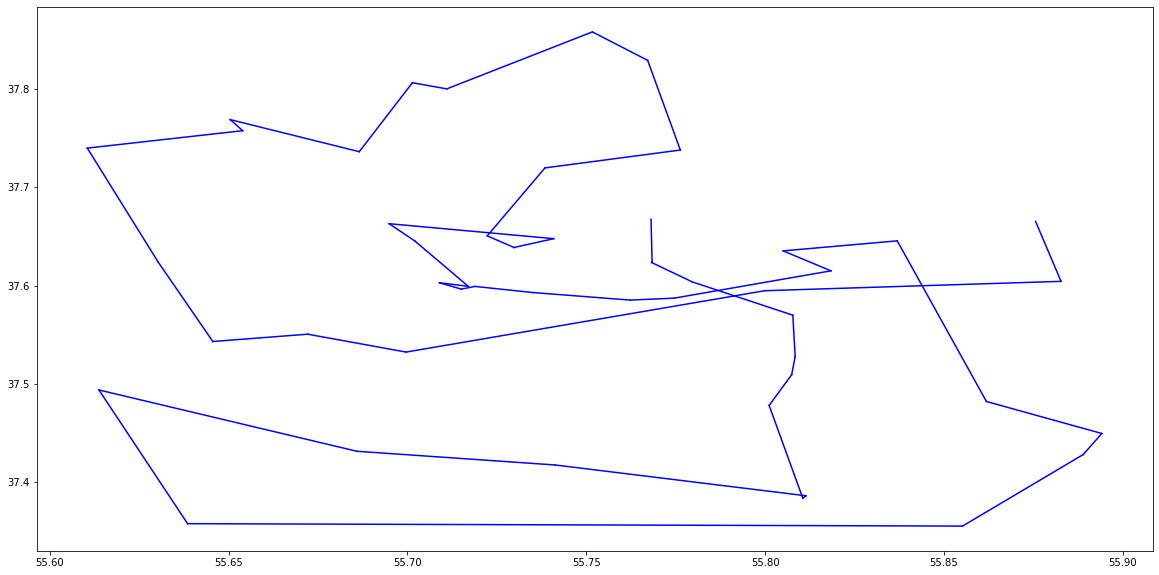

In [632]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt

"" "Вычислить общую длину пути, соответствующего хромосоме" ""
def countlen(chromo, distance, cityNum):
    lenth = 0
    for iii in range(cityNum - 1):
        lenth += distance[chromo[iii]][chromo[iii + 1]]
    lenth += distance[chromo[cityNum - 1]][chromo[0]]  # Плюс расстояние до начальной точки
    return lenth

"" "Создать начальную популяцию" ""
def crepopula(cityNum, M):
    popula = []  # Численность населения
    for ii in range(M):
        chromo = np.random.permutation(cityNum).tolist()   # Хромосома
        popula.append(chromo)
    return popula

"" "Рассчитайте совокупную вероятность каждого человека в популяции" ""
def countprobabily(popula,distance,cityNum):
    evall = []
    for chromo in popula:
        eval = max(30000 - countlen(chromo, distance,cityNum),0)  # Фитнес-функция
        evall.append(eval)
    seval = sum(evall)
    probabil = evall/seval   # Единственная вероятность
    probabily = probabil.copy()
    for i in range(1,len(popula)):
        probabily[i]=probabily[i]+probabily[i-1]  # Кумулятивная вероятность
    return probabily

"" "Рулетка отбирает потомство особей" ""
def lpd(popula,probabily,M):
    newpopula=[]
    for i in range(M):
        proba = rd.random()
        for ii in range(len(probabily)):
            if probabily[ii] >= proba:
                selechromo = popula[ii]
                break
        newpopula.append(selechromo)
    return newpopula

"" "Эвристическое пересечение: метод ближайшего соседа" ""
def crossover_nn(father1, father2,cityNum,distance):
    father_1 = father1.copy()
    father_2 = father2.copy()
    city0 = rd.randint(0, cityNum-1)  # Случайно выбрать город в качестве отправной точки
    son = [city0]
    while len(son) < len(father1):
        ord1 = father_1.index(city0)
        ord2 = father_2.index(city0)
        if ord1 == len(father_1)-1 :
            ord1 = -1
        if ord2 == len(father_1)-1 :
            ord2 = -1
        city1 = father_1[ord1 + 1]
        city2 = father_2[ord2 + 1]
        father_1.remove(city0)
        father_2.remove(city0)
        if distance[city0][city1] <= distance[city0][city2]:
            son.append(city1)
            city0 = city1
        else:
            son.append(city2)
            city0 = city2
    return son

"" "Эвристическая вариация" ""
import itertools
def variat2(father,cityNum,distance):
    or1 = rd.randint(0, cityNum - 1) # Случайно создать 5 местоположений
    or2 = rd.randint(0, cityNum - 1)
    or3 = rd.randint(0, cityNum - 1)
    or4 = rd.randint(0, cityNum - 1)
    or5 = rd.randint(0, cityNum - 1)
    nosame = list(set([or1, or2, or3, or4, or5]))
    ords = list(itertools.permutations(nosame, len(nosame)))
    sons = []               # Показать всех подчиненных представителей
    sonn = father.copy()
    for ord in ords:
        for ii in range(len(nosame)):
            sonn[nosame[ii]] = father[ord[ii]]
        sons.append(sonn)
    son_leng = []       # Рассчитать расстояние до всех детей
    for sonn in sons:
        leng = countlen(sonn, distance, cityNum)
        son_leng.append(leng)
    n = son_leng.index(min(son_leng))   # Выберите минимальное расстояние
    return sons[n]


def main():
    M = 100  # Численность населения
    cityNum = 50  # Количество городов, длина хромосомы
    "" "Координаты 52 городов" ""
#    cities = [[565, 575],[25, 185],[345, 750],[945, 685],[845, 655],[880, 660],[25, 230],[525, 1000],[580, 1175],
#              [650, 1130],[1605, 620],[1220, 580],[1465, 200],[1530, 5],[845, 680],[725, 370],[145, 665],[415, 635],
#              [510, 875],[560, 365],[300, 465],[520, 585],[480, 415],[835, 625],[975, 580],[1215, 245],[1320, 315],
#              [1250, 400],[660, 180],[410, 250],[420, 555],[575, 665],[1150, 1160],[700, 580],[685, 595],[685, 610],
#              [770, 610],[795, 645],[720, 635],[760, 650],[475, 960],[95, 260],[875, 920],[700, 500],[555, 815],
#              [830, 485],[1170, 65],[830, 610],[605, 625],[595, 360],[1340, 725],[1740, 245]]
    cities = test_short_lst
    "" "Создать матрицу расстояний" ""
#    distance = np.zeros([cityNum,cityNum])
#    for i in range(cityNum):
#        for j in range(cityNum):
#            distance[i][j] = pow((pow(cities[i][0]-cities[j][0],2)+pow(cities[i][1]-cities[j][1],2)),0.5)
    distance = distance_matrix.copy()

    "" "Инициализировать популяцию" ""
    popula = crepopula(cityNum, M)

    for n in range(800):  # Циклов
        "" "Эволюция населения" ""
        pc = 0.8  # Скорость кроссовера
        pv = 0.25  # Скорость мутации
        son = []
        ##пересекать
        crossgroup = []
        for i in range(M):
            cpb = rd.random()
            if cpb < pc:  # Меньше кросс-курса для пересечения
                crossgroup.append(popula[i])
        if len(crossgroup) % 2 == 1:  # Если нечетное
            del crossgroup[-1]
        if crossgroup != []:  # Эвристический кроссовер
            for ii in range(0, len(crossgroup), 2):
                sonc = crossover_nn(crossgroup[ii], crossgroup[ii + 1], cityNum, distance)
                son.append(sonc)
        ## Мутации
        variatgroup = []
        for j in range(M):
            vpb = rd.random()
            if vpb < pv:  # Мутация меньше скорости мутации
                variatgroup.append(popula[j])

        if variatgroup != []:
            for vag in variatgroup:
                sonv = variat2(vag, cityNum, distance)  # Эвристическая мутация
                son.append(sonv)

        "" "Рассчитайте совокупную вероятность каждой хромосомы" ""
        populapuls = popula + son
        probabily = countprobabily(populapuls, distance, cityNum)

        "" "Рулетка выбирает новый вид" ""
        popula = lpd(populapuls, probabily, M)

    "" "Выберите лучшую хромосому" ""
    opt_chr = popula[0]
    opt_len = countlen(popula[0], distance, cityNum)
    for chr in popula:
        chrlen = countlen(chr, distance, cityNum)
        if chrlen < opt_len:
            opt_chr = chr
            opt_len = chrlen
    print('Оптимальный путь:' + str(opt_chr))
    print('Оптимальное значение' + str(opt_len))

    "" "Нарисуйте карту" ""
    for cor in range(len(opt_chr)-1) :
        x = [cities[opt_chr[cor]][0],cities[opt_chr[cor+1]][0]]
        y = [cities[opt_chr[cor]][1],cities[opt_chr[cor+1]][1]]
        plt.plot(x,y,"b-")
    plt.show()

if __name__ =="__main__":
    main()

# Гугл

In [440]:
!pip install ortools --user

In [13]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [14]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = imput_matrix
#    data['demands'] = [0, 1, 1, 3, 6, 3, 6, 8, 8, 1, 2, 1, 2, 6, 6, 8, 8]
#    data['vehicle_capacities'] = [15, 15, 15, 15]
    data['num_vehicles'] = 2
    data['depot'] = 0
    return data


In [45]:
import random

In [112]:
rand_penalty = [random.randint(10,2000) for i in range(49)]

In [143]:
rand_penalty = [100, 10000]*24 + [100]

In [147]:
len(rand_penalty)

49

In [148]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

In [149]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

In [150]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [151]:
dimension_name = 'Time'
routing.AddDimension(
    transit_callback_index,
    15,  # no slack
    200,  # vehicle maximum travel distance
    False,  # start cumul to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [152]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
#    routing_enums_pb2.FirstSolutionStrategy.SAVINGS)

In [153]:
#search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.local_search_metaheuristic = (
#    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING)
search_parameters.time_limit.seconds = 60
#search_parameters.time_limit.seconds = 300
search_parameters.log_search = True

In [155]:
penalty = rand_penalty
for node, p in zip(range(1, len(data['distance_matrix'])),penalty):
    routing.AddDisjunction([manager.NodeToIndex(node)], p)

In [156]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    
    # Display dropped nodes.
    dropped_nodes = 'Dropped nodes:'
    dropped_nodes_lst=[]
    for node in range(routing.Size()):
        if routing.IsStart(node) or routing.IsEnd(node):
            continue
        if solution.Value(routing.NextVar(node)) == node:
            dropped_nodes += ' {}'.format(manager.IndexToNode(node))
            dropped_nodes_lst.append(manager.IndexToNode(node))
    print(dropped_nodes)
    
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}min\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}min'.format(max_route_distance))
    return max_route_distance, dropped_nodes_lst

In [157]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    a = print_solution(data, manager, routing, solution)

Objective: 19923
Dropped nodes: 11 13 15 17 21 23 27 29 31 35 37 39 41 43 45 47 49
Route for vehicle 0:
 0 ->  33 ->  12 ->  4 ->  24 ->  14 ->  19 ->  1 ->  10 ->  36 ->  48 ->  42 ->  5 ->  22 ->  46 ->  9 -> 0
Distance of the route: 161min

Route for vehicle 1:
 0 ->  26 ->  38 ->  28 ->  30 ->  18 ->  25 ->  32 ->  8 ->  20 ->  44 ->  7 ->  34 ->  6 ->  16 ->  40 ->  3 ->  2 -> 0
Distance of the route: 162min

Maximum of the route distances: 162min


In [159]:
a[1]

[11, 13, 15, 17, 21, 23, 27, 29, 31, 35, 37, 39, 41, 43, 45, 47, 49]

In [163]:
for i in [1,
 5,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 41,
 43,
 45,
 47,
 49]:
    print(rand_penalty[i-1])

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


In [98]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    dimension_name = 'Time'
    routing.AddDimension(
        transit_callback_index,
        15,  # no slack
        300,  # vehicle maximum travel distance
        False,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
#    # Add Capacity constraint.
#    def demand_callback(from_index):
#        """Returns the demand of the node."""
#        # Convert from routing variable Index to demands NodeIndex.
#        from_node = manager.IndexToNode(from_index)
#        return data['demands'][from_node]

#    demand_callback_index = routing.RegisterUnaryTransitCallback(
#        demand_callback)
#    routing.AddDimensionWithVehicleCapacity(
#        demand_callback_index,
#        0,  # null capacity slack
#        data['vehicle_capacities'],  # vehicle maximum capacities
#        True,  # start cumul to zero
#        'Capacity')

    # Allow to drop nodes.
    penalty = rand_penalty
    for node, p in zip(range(1, len(data['distance_matrix'])),penalty):
        routing.AddDisjunction([manager.NodeToIndex(node)], p)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(60)

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print_solution(data, manager, routing, assignment)


if __name__ == '__main__':
    main()

Objective: 23950
Dropped nodes: 34 36 48 49
Route for vehicle 0:
 0 ->  2 ->  16 ->  40 ->  3 ->  35 ->  23 ->  10 ->  42 ->  5 ->  22 ->  46 ->  9 ->  6 ->  13 ->  43 ->  31 ->  7 ->  44 ->  15 ->  4 ->  24 -> 0
Distance of the route: 222min

Route for vehicle 1:
 0 ->  33 ->  28 ->  30 ->  18 ->  25 ->  38 ->  41 ->  26 ->  8 ->  20 ->  37 ->  45 ->  11 ->  29 ->  47 ->  32 ->  27 ->  12 ->  14 ->  19 ->  1 ->  39 ->  21 ->  17 -> 0
Distance of the route: 224min

Maximum of the route distances: 224min


# Метод ближайшего соседа

In [559]:
res_df.head(3)

,start_point_id,end_point_id,start_point,end_point,car_distance_min,car_distance_m
0,0,1,"[55.762316, 37.5854656]","[55.8114155, 37.3864134]",21.61,18241.1
1,0,2,"[55.762316, 37.5854656]","[55.774565, 37.5874377]",3.93,2535.0
2,0,3,"[55.762316, 37.5854656]","[55.807749, 37.570132]",12.61,7920.1


In [89]:
imput_matrix = [list(map(lambda x: int(np.ceil(x)), row)) for row in distance_matrix]

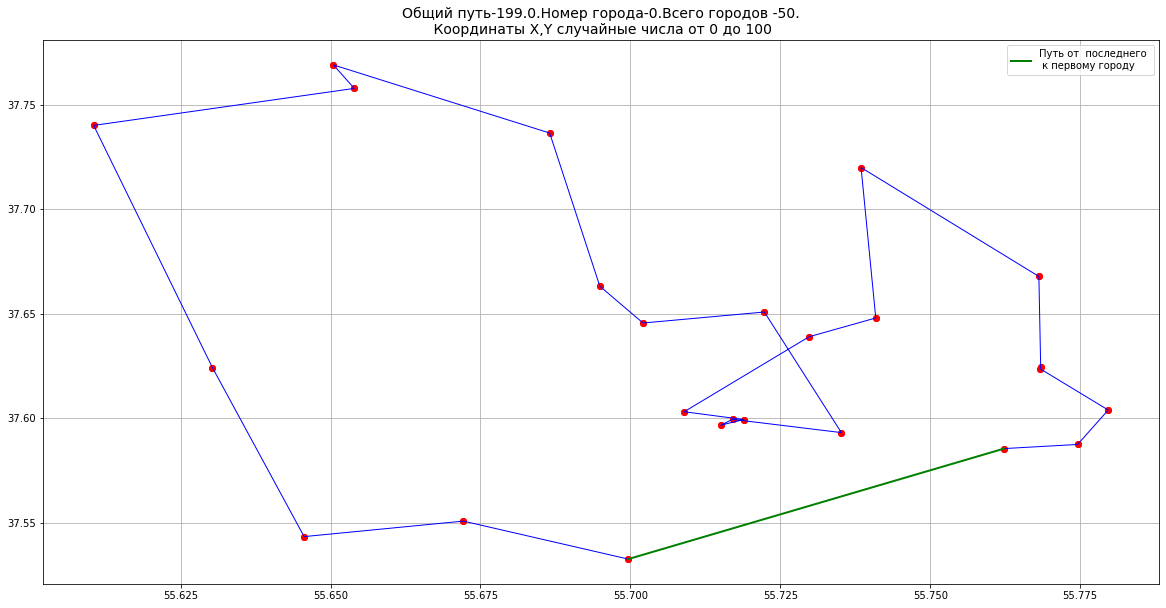

In [615]:
from numpy import exp,sqrt
n=50;m=100;ib=0;way=[];a=0
#X=np.random.uniform(a,m,n)
#Y=np.random.uniform(a,m,n)

X = [x[0] for x in test_short_lst]
Y = [x[1] for x in test_short_lst]
#X=[10, 10, 100,100 ,30, 20, 20, 50, 50, 85, 85, 75, 35, 25, 30, 47, 50]
#Y=[5, 85, 0,90,50, 55,50,75 ,25,50,20,80,25,70,10,50,100]
#n=len(X)
#M = np.zeros([n,n]) # Шаблон матрицы относительных расстояний между пунктами
#for i in np.arange(0,n,1):
#         for j in np.arange(0,n,1):
#                  if i!=j:
#                           M[i,j]=sqrt((X[i]-X[j])**2+(Y[i]-Y[j])**2)# Заполнение матрицы
#                  else:
#                    M[i,j]=float('inf')#Заполнение главной диагонали матрицы     
#                    
#
M = distance_matrix.copy()
way.append(ib)
for i in np.arange(1,n,1):
         s=[]
         for j in np.arange(0,n,1):                  
                  s.append(M[way[i-1],j])
         way.append(s.index(min(s)))# Индексы пунктов ближайших городов соседей
         for j in np.arange(0,i,1):
                  M[way[i],way[j]]=float('inf')
                  M[way[i],way[j]]=float('inf')
#S=sum([sqrt((X[way[i]]-X[way[i+1]])**2+(Y[way[i]]-Y[way[i+1]])**2) for i in np.arange(0,n-1,1)])+ sqrt((X[way[n-1]]-X[way[0]])**2+(Y[way[n-1]]-Y[way[0]])**2)
way_full = way + [ib]
S = 0
for i in range(n):
    S+=distance_matrix[way_full[i]][way_full[i+1]]

plt.title('Общий путь-%s.Номер города-%i.Всего городов -%i.\n Координаты X,Y случайные числа от %i до %i'%(round(S,3),ib,n,a,m), size=14)
X1=[X[way[i]] for i in np.arange(0,n,1)]
Y1=[Y[way[i]] for i in np.arange(0,n,1)]    
plt.plot(X1, Y1, color='r', linestyle=' ', marker='o')
plt.plot(X1, Y1, color='b', linewidth=1)   
X2=[X[way[n-1]],X[way[0]]]
Y2=[Y[way[n-1]],Y[way[0]]]
plt.plot(X2, Y2, color='g', linewidth=2,  linestyle='-', label='Путь от  последнего \n к первому городу') 
plt.legend(loc='best')
plt.grid(True)
plt.show()  

# mlrose

In [634]:
!pip install mlrose

  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2375 sha256=3b18ced45de0dc2f545659a51a560a19d6535221e8a4fab22972b97513446eee
  Stored in directory: c:\users\anna\appdata\local\pip\cache\wheels\84\3f\80\e49971719e76c0387733de7973744b4b19b01dc14afcce8829
Successfully built sklearn


In [3]:
import six
import sys
import scipy
sys.modules['sklearn.externals.six'] = six
import mlrose

In [47]:
coords_list = [(1, 1), (4, 2), (5, 2), (6, 4), (4, 4), (3, 6), (1, 5), (2, 3)]

dist_list = [(0, 1, 3.1623), (0, 2, 4.1231), (0, 3, 5.8310), (0, 4, 4.2426), \
             (0, 5, 5.3852), (0, 6, 4.0000), (0, 7, 2.2361), (1, 2, 1.0000), \
             (1, 3, 2.8284), (1, 4, 2.0000), (1, 5, 4.1231), (1, 6, 4.2426), \
             (1, 7, 2.2361), (2, 3, 2.2361), (2, 4, 2.2361), (2, 5, 4.4721), \
             (2, 6, 5.0000), (2, 7, 3.1623), (3, 4, 2.0000), (3, 5, 3.6056), \
             (3, 6, 5.0990), (3, 7, 4.1231), (4, 5, 2.2361), (4, 6, 3.1623), \
             (4, 7, 2.2361), (5, 6, 2.2361), (5, 7, 3.1623), (6, 7, 2.2361)]

In [61]:
coords_list = [(x[0], x[1])  for x in test_short_lst]
dist_list = [(res_df.start_point_id.iloc[i], res_df.end_point_id.iloc[i], res_df.car_distance_min.iloc[i]) \
             for i in range(len(res_df))]

In [72]:
fitness_coords = mlrose.TravellingSales(coords = coords_list)
fitness_dists = mlrose.TravellingSales(distances = dist_list)

In [75]:
problem_fit = mlrose.TSPOpt(length = 50, 
                            fitness_fn = fitness_coords,
                            #coords=fitness_coords,
                            distances= fitness_dists,
                            maximize=False)

In [104]:
%%time
best_state, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, 
					      max_attempts = 1000, random_state = 2)

print('The best state found is: ', best_state)

print('The fitness at the best state is: ', best_fitness)

The best state found is:  [24 29 13  2  8 34 16 19 31 21 20 14 49 25 47 37 17 39 40 38  3 28  9 48
 42 11  7 33  6  1 27 23 15 35  4 12 18 22 10 43 41 32 36 45 44 26  5 46
 30  0]
The fitness at the best state is:  6.128060765605757
Wall time: 1min 52s


In [105]:
S = 0
way_full =[0]+list(best_state)
for i in range(50):
    S+=distance_matrix[way_full[i]][way_full[i+1]]

In [106]:
S

1167.29

In [97]:
from mlrose.decay import GeomDecay

In [107]:
%%time
best_state, best_fitness = mlrose.simulated_annealing(problem_fit, schedule=GeomDecay(), max_attempts=1000,
                        random_state=2)


Wall time: 2.23 s


In [108]:
S = 0
way_full =[0]+list(best_state)
for i in range(50):
    S+=distance_matrix[way_full[i]][way_full[i+1]]
S

1061.44